**End to end Face Detection**

Before we start with the project we need to setup our environment and get the data ready which can be done as follow:
* installing all the dependencies
* collecting images

In [1]:
#getting all the dependencies 
%pip install labelme tensorflow opencv-python matplotlib albumentations

Note: you may need to restart the kernel to use updated packages.


**Collecting images using OpenCV**

we will be using OpenCV to access our images and them annotate them using Label me...

In [2]:
#importing all the libraries
import os
import time
import uuid #giving our images a unique ID 
import cv2

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [10]:
#using a custom for loop to capture our images and saving them in the defined path for further analysis
cap = cv2.VideoCapture(0) #change this based on your camra input
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [4]:
#now we need to annotate our images using LabelMe
!labelme

2024-10-26 23:06:25,691 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\Amir\.labelmerc


**Bulding our image intergration function**

after capturing and annotating our images now we need to review our data and then build a function that would load them.


In [5]:
#importing our libraries:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [6]:
#loading our images:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')
images.as_numpy_iterator().next()

b'data\\images\\daadb6a9-93e2-11ef-9efe-98bb1e1c5484.jpg'

In [7]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [8]:
images = images.map(load_image)

In [9]:
images.as_numpy_iterator().next()

array([[[125, 118, 108],
        [125, 118, 108],
        [125, 118, 108],
        ...,
        [124, 126, 123],
        [124, 126, 123],
        [123, 125, 122]],

       [[123, 116, 106],
        [124, 117, 107],
        [124, 117, 107],
        ...,
        [123, 125, 122],
        [123, 125, 122],
        [122, 124, 121]],

       [[122, 115, 107],
        [123, 116, 108],
        [124, 117, 109],
        ...,
        [123, 127, 126],
        [122, 126, 125],
        [121, 125, 124]],

       ...,

       [[ 24,  33,  40],
        [ 24,  33,  38],
        [ 28,  33,  37],
        ...,
        [ 41,  46,  50],
        [ 45,  49,  52],
        [ 46,  50,  53]],

       [[ 19,  34,  41],
        [ 21,  34,  40],
        [ 25,  35,  36],
        ...,
        [ 40,  45,  49],
        [ 41,  46,  50],
        [ 42,  47,  51]],

       [[ 17,  34,  41],
        [ 20,  35,  40],
        [ 25,  37,  37],
        ...,
        [ 39,  44,  48],
        [ 39,  44,  48],
        [ 39,  44,  48]]

In [10]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

**Visualising our images**

in this section we will be using Matplotlib to visualise our raw images

which can help us to understand our data furthemore.


In [11]:
image_generator = images.batch(4).as_numpy_iterator()

In [12]:
plot_images = image_generator.next()

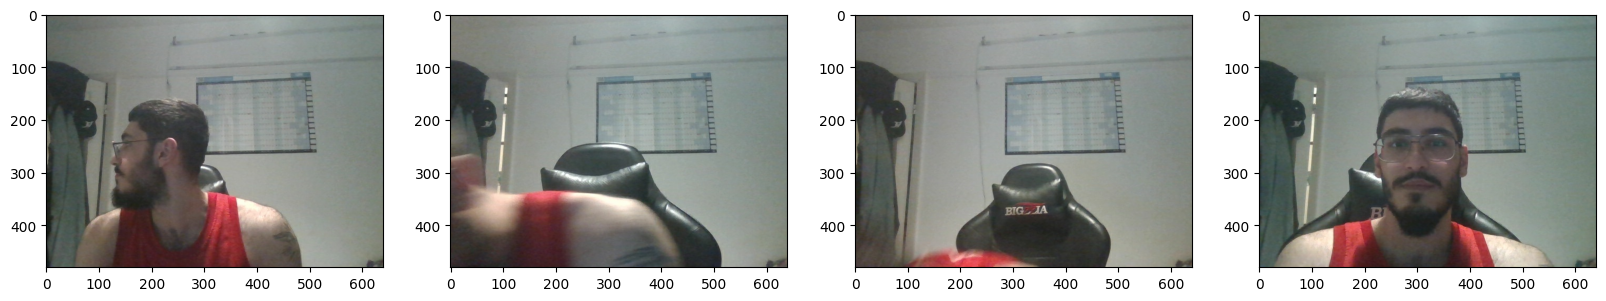

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()
#test

**Managing our un-augmented data**

we also need to split our data into trining and testing set which will be done manually:

so I have split the images into the followings:
* 63 for the training images.
* 14 for test.
* 13 for validation


In [19]:
#now moving our labels into the labels for each datasets using a for loop
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

**performing image augmentation**

Since we only have 90 images (which is not enough, it never is enough) now we have to augment our images so we can train our model more effectively. this process will be done using Albumentations.

In [60]:
import albumentations as alb

In [61]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

**Loading our images**

in this section we will be using OpenCV and JSON to load our images 

In [62]:
#loading up a random image
img = cv2.imread(os.path.join('data','train', 'images','d9228308-93e2-11ef-a331-98bb1e1c5484.jpg'))

In [63]:
#loading in out label for the same image 
with open(os.path.join('data', 'train', 'labels', 'd9228308-93e2-11ef-a331-98bb1e1c5484.json'), 'r') as f:
    label = json.load(f)

In [64]:
label['shapes'][0]['points']

[[198.84615384615384, 169.6703296703297],
 [335.1098901098901, 381.2087912087912]]

**getting our image coordinations**

in order to input our images into our model we need to understand what is our input image size, resolution etc.
* Note: since we're using Albumentations we need to make sure that our bounding box coordinations are correct e.g., it should be as follow:
[x_min, y_min, x_max, y_max]. The values are normalized by dividing the pixel coordinates for the x- and y-axis by the image's width and height.


In [65]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [66]:
coords

[198.84615384615384, 169.6703296703297, 335.1098901098901, 381.2087912087912]

In [67]:
#getting our image size:
img.shape

(480, 640, 3)

In [68]:
coords = list(np.divide(coords, [640,480,640,480]))

In [69]:
coords

[np.float64(0.31069711538461536),
 np.float64(0.3534798534798535),
 np.float64(0.5236092032967032),
 np.float64(0.7941849816849816)]

**Augmentations**

in this section we will be adding our augmented images and view our results.
* in this section we will fine-tune our "augmentor" function that we built earlier and see if it works. Then in the next section we will apply the augmentor function to all the images.


In [74]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [75]:
augmented['bboxes'][0][2:]

[0.707008556789822, 0.780463981628418]

In [76]:
augmented['bboxes']

[[0.4042002190483941,
  0.3103785196940104,
  0.707008556789822,
  0.780463981628418]]

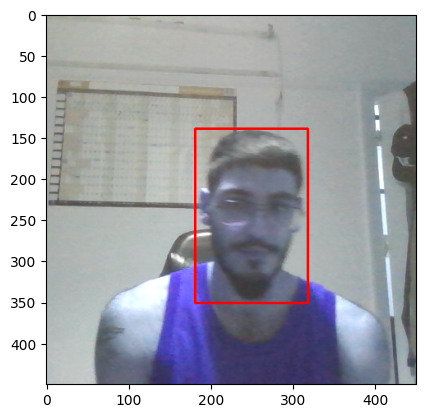

In [77]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),      #top most coordinates 
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),      #bottom most coordinates
                    (255,0,0), 2)

plt.imshow(augmented['image'])

**building our Pipeline**

in this section we will be building a pipeline that would apply our augmentation process.


In [79]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

**loading our augmented images to TensorFlow**

in the pervious section we have successfully created augmented images for all the three sets train, val and test.

now we need to add them inside of TensorFlow:


In [80]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [81]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [82]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [85]:
train_images.as_numpy_iterator().next()

array([[[0.70055145, 0.41084558, 0.32408088],
        [0.5620711 , 0.3064951 , 0.21960784],
        [0.46832108, 0.24019608, 0.22254902],
        ...,
        [0.48400736, 0.5310662 , 0.48658088],
        [0.48694852, 0.51979166, 0.46832108],
        [0.47297794, 0.5025123 , 0.45061275]],

       [[0.71642154, 0.42132354, 0.31789216],
        [0.6194853 , 0.34595588, 0.24987745],
        [0.5029412 , 0.25484067, 0.21752451],
        ...,
        [0.4867647 , 0.529902  , 0.4985294 ],
        [0.47806373, 0.51862746, 0.4833946 ],
        [0.47334558, 0.51256126, 0.4723652 ]],

       [[0.7380515 , 0.45042893, 0.35202205],
        [0.7064951 , 0.42512256, 0.3266544 ],
        [0.55514705, 0.30061275, 0.21519607],
        ...,
        [0.4970588 , 0.5441176 , 0.50490195],
        [0.48284313, 0.529902  , 0.49068627],
        [0.46844363, 0.51550245, 0.47628677]],

       ...,

       [[0.5276348 , 0.5511642 , 0.53547794],
        [0.5367647 , 0.5602941 , 0.5446078 ],
        [0.5254902 , 0

**creating our labels**

in this section we will be creating our train, test and val labels so we can get our data ready for our model

In [86]:
#creating a label loading function e.g., adding our bounding box
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [87]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [88]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [89]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [90]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.0823, 0.0705, 0.5083, 0.6846], dtype=float16))

**images and labels** 

in this section we will be combining our labels and our images 

In [91]:
#checking our partitions length 
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

Now we can create our final Database

In [92]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [93]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [94]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [105]:
#checking the shape of our image
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [106]:
#checking the label of our image
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.     , 0.08905, 0.455  , 0.8364 ],
        [0.3132 , 0.11725, 0.6343 , 0.5654 ],
        [0.1316 , 0.1327 , 0.6064 , 0.7544 ],
        [0.4526 , 0.1815 , 0.7666 , 0.639  ],
        [0.378  , 0.2751 , 0.622  , 0.5977 ],
        [0.5757 , 0.0812 , 1.     , 0.959  ],
        [0.365  , 0.376  , 0.6787 , 0.8022 ],
        [0.     , 0.094  , 0.2695 , 0.901  ]], dtype=float16))

**Visualizing our images and labels**

in this section we will attempt to visualize our combined images with their labels.

In [117]:
data_samples = train.as_numpy_iterator()

In [124]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


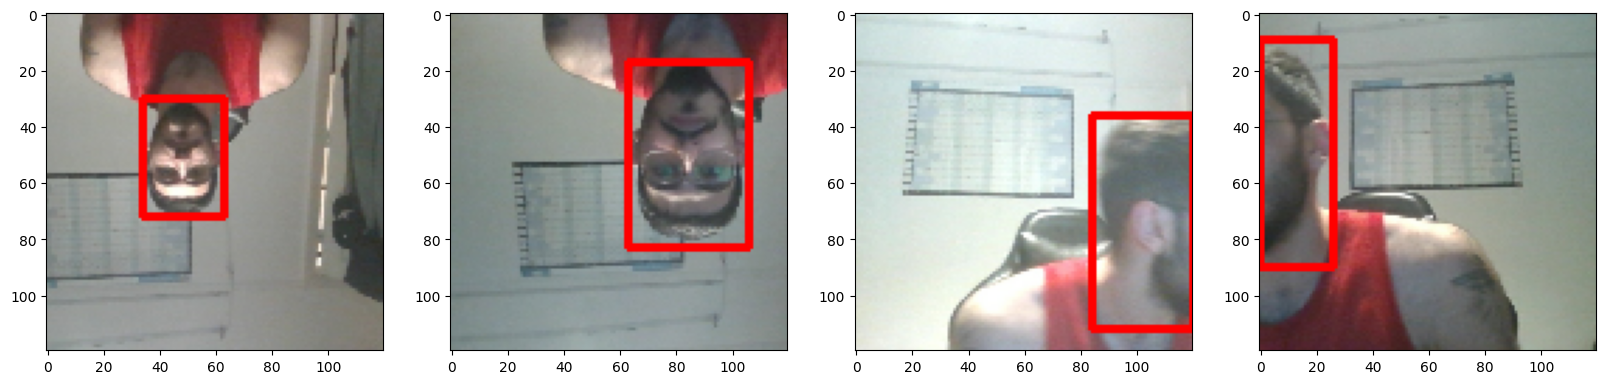

In [173]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx].copy()
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)


**Creating our model**

Finally it's time to create our Deep Learning model, which we will be doing that by using the Functional API.


In [174]:
#importing all the dependencies

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [175]:
#in this project we will be using the VGG16
vgg = VGG16(include_top=False)

In [176]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Creating instance of the Network

In [178]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

**Testing**

in this section we will be testing our Neural Network

In [179]:
facetracker = build_model()

In [180]:
facetracker.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │      2,049 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 4)         │      8,196 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [181]:
#reminder: X is our images and y is our labels 
X, y = train.as_numpy_iterator().next()

In [182]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


In [183]:
classes, coords

(array([[0.58033997],
        [0.55971956],
        [0.45204976],
        [0.56300604],
        [0.5240274 ],
        [0.6216947 ],
        [0.49768084],
        [0.47237095]], dtype=float32),
 array([[0.36443093, 0.39028236, 0.49622226, 0.60450494],
        [0.309601  , 0.348737  , 0.48112398, 0.5700412 ],
        [0.27322406, 0.3813135 , 0.57038087, 0.581902  ],
        [0.360534  , 0.3871061 , 0.44512036, 0.61207265],
        [0.38619915, 0.2888482 , 0.4864305 , 0.60354364],
        [0.29202634, 0.341096  , 0.51718295, 0.58356285],
        [0.36280227, 0.36461833, 0.5578693 , 0.5752867 ],
        [0.32007438, 0.29555145, 0.5264043 , 0.65239197]], dtype=float32))

Defining our loss and our optimization function

In [184]:
#one way to go about finding out the LR is 75% of the original learning rate after each epoch. meaning we have to slow down the learning rate over time...
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [185]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

d:\Coding Projects\Deep-Face-Detection\.venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Create Localization Loss and Classification Loss

In [186]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [187]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

Test and Loss Metrics

In [188]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.636860966682434>

In [189]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6721357107162476>

In [190]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.636860966682434>

**Training the Neural Network**

in this section we will create a custom model class and attempt to train our Neural Network

In [209]:
class FaceTracker(Model): 
    def __init__(self, eyetracker, **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        X, y = batch

        # Ensure the shapes of y[0] and y[1] are as expected
        y[0].set_shape([None, 1])  # Replace `num_classes` with the actual number of classes
        y[1].set_shape([None, 4])  # 4 for bounding box coordinates (x_min, y_min, x_max, y_max)
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)

            # Calculate the classification and localization loss
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss + 0.5 * batch_classloss
            
        # Compute gradients and apply them
        grads = tape.gradient(total_loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))
        
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def test_step(self, batch, **kwargs): 
        X, y = batch

        # Ensure shapes in test_step as well
        y[0].set_shape([None, 1])  
        y[1].set_shape([None, 4])             
        
        classes, coords = self.model(X, training=False)
        
        # Calculate losses
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss
        
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [210]:
model = FaceTracker(facetracker)

In [211]:
model.compile(opt, classloss, regressloss)

Training:

In [212]:
logdir='logs'

In [213]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [214]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 99s 203ms/step - class_loss: 0.1184 - regress_loss: 0.3676 - total_loss: 0.4267 - val_total_loss: 0.0484 - val_class_loss: 5.6325e-04 - val_regress_loss: 0.0481
Epoch 2/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 95s 199ms/step - class_loss: 0.0320 - regress_loss: 0.1195 - total_loss: 0.1355 - val_total_loss: 0.0251 - val_class_loss: 0.0013 - val_regress_loss: 0.0245
Epoch 3/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 96s 202ms/step - class_loss: 0.0223 - regress_loss: 0.0776 - total_loss: 0.0887 - val_total_loss: 0.0428 - val_class_loss: 0.0024 - val_regress_loss: 0.0416
Epoch 4/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 96s 202ms/step - class_loss: 0.0151 - regress_loss: 0.0545 - total_loss: 0.0620 - val_total_loss: 0.0239 - val_class_loss: 0.0036 - val_regress_loss: 0.0221
Epoch 5/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 97s 204ms/step - class_loss: 0.0154 - regress_loss: 0.0616 - total_loss: 0.0693 - val_total_loss: 0.0097 - val_class_loss: 2.0500e-04 - val_regress_loss: 0.0096
Epoch 6

**Making a prediction with our models** 

Since the models has successfully trained on our data set now we can test the model and see it's acuuracy for our self!

In [226]:
test_data = test.as_numpy_iterator()

In [227]:
test_sample = test_data.next()

In [228]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


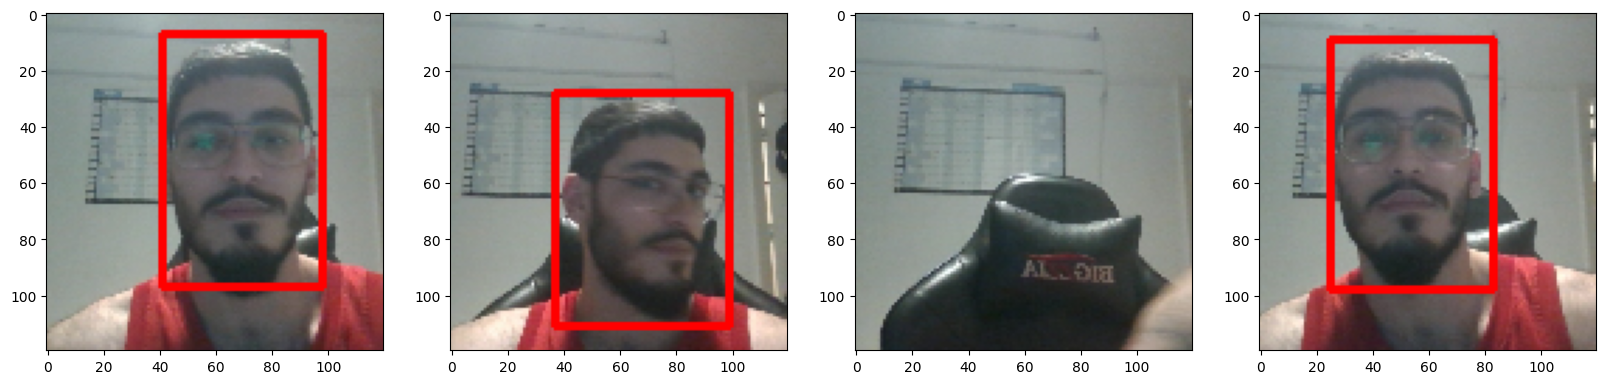

In [229]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20)) 
for idx in range(4): 
    sample_image = test_sample[0][idx].copy()  # Make a writable copy
    sample_coords = yhat[1][idx]
    
    # Draw rectangle if the confidence score is above 0.9
    if yhat[0][idx] > 0.9:
        cv2.rectangle(
            sample_image, 
            tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
            tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)), 
            (255, 0, 0), 2
        )
    
    ax[idx].imshow(sample_image)

Saving the model


In [230]:
from tensorflow.keras.models import load_model

In [233]:
facetracker.save('facetracker.keras')

In [232]:
facetracker = load_model('facetracker.h5')

**Real time testing**

Finally, the final step of this project is to use our saved model and test it inm real time using our own camera!

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()